In [7]:
%matplotlib widget

import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
from ibsen.orbit import Orbit
from ibsen.winds import Winds
from ibsen.ibs import IBS


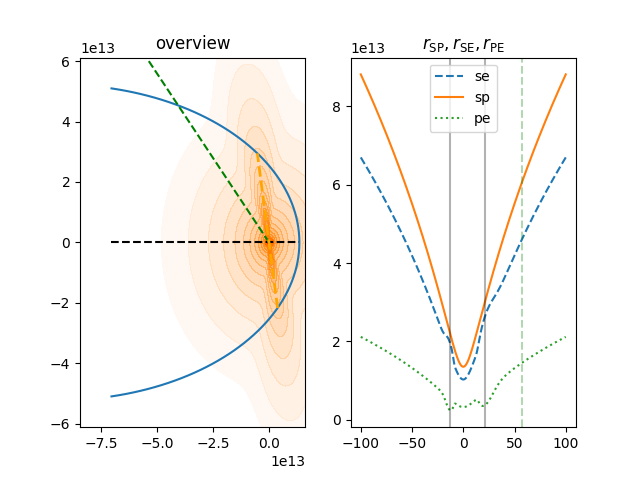

In [8]:
plt.close('all')
DAY = 86400.
AU = 1.5e13

sys_name = 'psrb' 
orb = Orbit(sys_name = sys_name, n=1003)
winds_full = Winds(orbit=orb, sys_name = sys_name, alpha=10/180*pi, incl=23*pi/180,
              f_d=165, f_p=0.1, delta=0.02, np_disk=3, rad_prof='pl', r_trunk=None,
             height_exp=0.25,
                 ns_b_model = 'linear', ns_b_ref = 1, ns_r_ref = 1e13,
                 opt_b_model = 'linear', opt_b_ref = 0, opt_r_ref = 1e13,)
winds_full.peek(showtime=(-100*DAY, 100*DAY))
plt.show()


The class ``NonstatElectronEvol`` is for the non-stationary evolution of the electrons in one-zone model. It solves the equation
\begin{equation}
    \frac{\partial n}{\partial t} + \frac{\partial (n \dot E)}{\partial t} = f_\mathrm{inj},
\end{equation}
with $n=n(E, t)$ an electron spectrum in the emission zone [1/eV], $\dot E=\dot E(E, t)$ a (negative) loss rate for a single electron [eV/s], and $f_\mathrm{inj}=f_\mathrm{inj}(E, t)$ an injection function [1/eV/s].  

Currently $f_\mathrm{inj}$ is normalized so that for every time $t$, $\int_0^\infty f(E', t) dE' = \mathrm{norm}/2$. So currently the injection doesn't depend on time, but the solver allows time dependence. The choice of $1/2$ in normalization was made to associate `norm` with the total amount of particles from the pulsar (per unit of time), so that the half of it is injected in the forward hemisphere. Idk, we may remove $1/2$, who cares.

For this class, you need to provide a Winds object, times of start/stop relative to the periastron passage, some e-grid parameters and injection function parameters. You also need to provide initial conditions either in a form of a keyword to take zero-condition or stationary-at-initial-time condition, OR as a tabulated $(e, n_0(e))$.

Internally, the solver for the time-dependent $\dot E, f_\mathrm{inj}$ solve the time-independent equation over $[t_i, t_{i+1}]$ with averaged values of time-dependent functions using the analog of Denys solver (but faster; the fully vectorized version of the characteristics method). The solver thus applies the  internal Denys-like solver for many steps over time, either marching with a constant $dt$ or using an adaptive step (slower, obv). If adaptive time-steps are used, the internal solver compares the solution after the step $dt$ with a solution by two consequtive steps $dt/2, dt/2$. If a relative error $> \varepsilon_\mathrm{big}$, the step is reduced by a factor of 2; If a relative error $< \varepsilon_\mathrm{small}$, the step is increased by a factor of 1.3 (empirically found to give good results).

In [9]:
plt.close('all')

from ibsen.el_ev import NonstatElectronEvol
import time
# el = NonstatElectronEvol(winds=winds_full, t_start=-7*DAY, t_stop=47*DAY,
#                         emin=1e9, emax=1e13, emin_grid=1e8, emax_grid=1e13,
#                         n_t=1001, p_e=1.7, init_distr='stat', eps_big=1e-2, eps_small=3e-3,
#                         n_dec_e=201)
el = NonstatElectronEvol(         
    winds=winds_full,
    t_start=-70*DAY,
    t_stop=70*DAY,
    n_t=105, # not used, haha!
    to_inject_e = 'ecpl',      #|\
    to_inject_theta = '3d',    #|\
    ecut = 1.e12,              #|\
    p_e = 1.7,                 #|\
    norm_e = 1.e37,            #|\
    eta_a = 1.,                #|---
    eta_syn = 1.,              #| -------- >     same as in ElectronsOnIBS
    eta_ic = 1.,               #|---
    emin = 1e9,                #|/
    emax = 5.1e14,             #|/
    to_cut_e = True,           #|/
    emin_grid=3e8,             #|/
    emax_grid=6e14,            #|/
    coef_down=10, # to extend the actual e-grid down to emin_grid/coef_down              
     n_dec_e=135,  # number of nodes per decade for e-grid        

     init_distr='stat', # can be either 'stat' (stat distribution at t_start)
                        # or 'zero' (n0 \equiv 0 at t_start)
                        # or a tuple (e_grid, n_0(e_grid)).
    
     eps_small = 1e-3, # see description 
     eps_big = 3e-3, # see description 
     adaptive_dt = True, # True/False
     dt_min = 1e-2 * DAY, # floor for dt. If adaptive_dt=False, it's used as a constant dt.
     dt_max = 5 * DAY, # ceiling for dt
     dt_first=None  # First dt. If None, dt_first=dt_
)
start = time.time()
ts, es, ns = el.calculate(to_return=True)
# e_ = es[1, :]
e_ = es
print(time.time() - start)
plt.show()


44.75496792793274


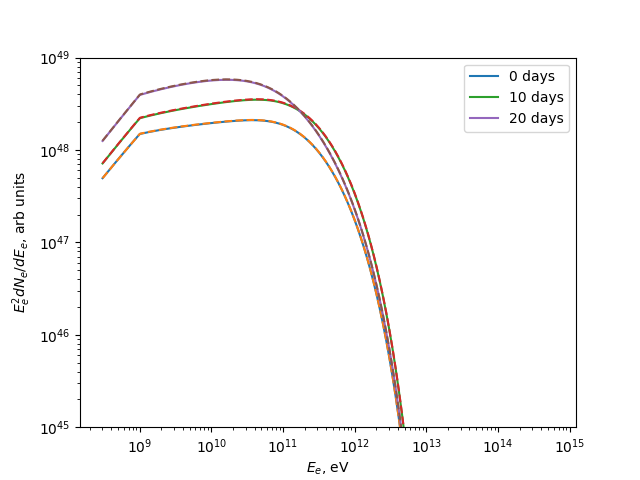

In [10]:
# plt.plot(e_, ns[0, :]*e_**2)
plt.close('all')

"""
Let's compare the calculated spectra at T = 0, 10 days, 20 days with the 
simultaneous stationary spectra.
"""
# print(el.ts.shape)
# print(el.dNe_des.shape)
# print(type(el.ts))
# print(type(el.dNe_des))
plt.plot(e_, el.dn_de(0)*e_**2, label='0 days')
plt.plot(e_, el.stat_distr_at_time(0, e_)*e_**2, ls='--')

plt.plot(e_, el.dn_de(10*DAY)*e_**2, label='10 days')
plt.plot(e_, el.stat_distr_at_time(10*DAY, e_)*e_**2, ls='--')

plt.plot(e_, el.dn_de(20*DAY)*e_**2, label='20 days')
plt.plot(e_, el.stat_distr_at_time(20*DAY, e_)*e_**2, ls='--')

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$E_e^2 dN_e/dE_e$, arb units')
plt.xlabel(r'$E_e$, eV')
plt.legend()

plt.ylim(1e45, 1e49)
plt.show()

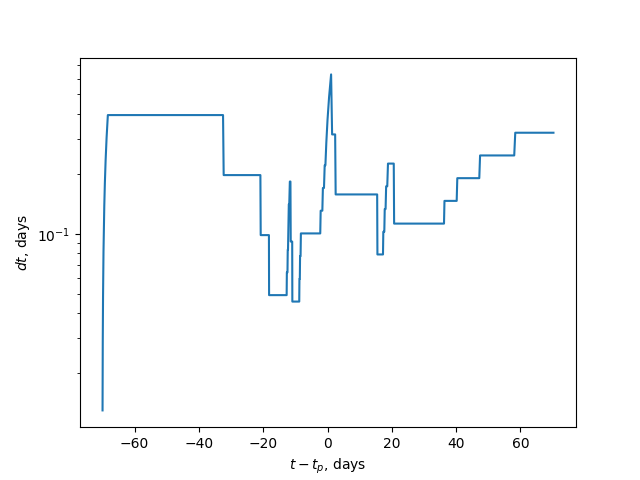

In [14]:
plt.close('all')
"""
The dependence of the time step dt on time.
"""
from scipy.integrate import trapezoid, cumulative_trapezoid, solve_ivp
dt = ts[1:] - ts[:-1]
plt.plot(ts[1:]/DAY, dt/DAY)
plt.ylabel(r'$dt$, days')
plt.xlabel(r'$t-t_p$, days')
plt.yscale('log')
plt.show()

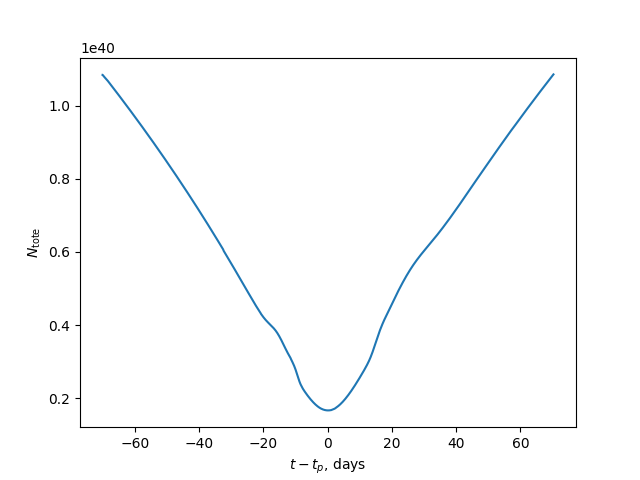

In [13]:
plt.close('all')
"""
The dependence of the total number of e+- on time.
"""
mask = np.logical_and(e_ < 1e13, e_ > 1e9)
Ntot = trapezoid(ns[:, mask], e_[mask], axis=1)
plt.plot(ts/DAY, Ntot)
plt.ylabel(r'$N_\mathrm{tot e}$')
plt.xlabel(r'$t-t_p$, days')
plt.show()